In [9]:
import numpy as np
import pandas as pd 
import keras
from scipy.special import expit 
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from keras.layers import Dense, Input
from keras.models import Model, Sequential
from keras.utils import to_categorical
from causalgraphicalmodels import CausalGraphicalModel

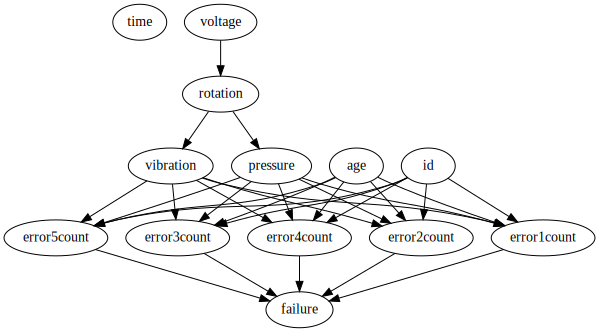

In [2]:
machine_SCM = CausalGraphicalModel(
    nodes=['voltage', 'time', 'rotation', 'pressure', 'vibration', 'id', 'age', 'error1count', 'error2count', 'error3count', 'error4count', 'error5count', 'failure'],
    edges=[
        ('voltage', 'rotation'),
        ('rotation', 'pressure'),
        ('rotation', 'vibration'),

        ('pressure', 'error1count'),
        ('vibration', 'error1count'),
        ('id', 'error1count'),
        ('age', 'error1count'),
        ('error1count', 'failure'),

        ('pressure', 'error2count'),
        ('vibration', 'error2count'),
        ('id', 'error2count'),
        ('age', 'error2count'),
        ('error2count', 'failure'),

        ('pressure', 'error3count'),
        ('vibration', 'error3count'),
        ('id', 'error3count'),
        ('age', 'error3count'),
        ('error3count', 'failure'),

        ('pressure', 'error4count'),
        ('vibration', 'error4count'),
        ('id', 'error4count'),
        ('age', 'error4count'),
        ('error4count', 'failure'),

        ('pressure', 'error5count'),
        ('vibration', 'error5count'),
        ('id', 'error5count'),
        ('age', 'error5count'),
        ('error5count', 'failure')
    ]
)
machine_SCM.draw()


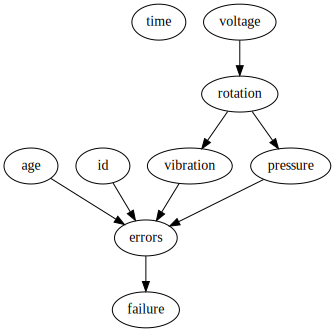

In [3]:
machine_SCM_simple = CausalGraphicalModel(
    nodes=['voltage', 'time', 'rotation', 'pressure', 'vibration', 'id', 'age', 'errors', 'failure'],
    edges=[
        ('voltage', 'rotation'),
        ('rotation', 'pressure'),
        ('rotation', 'vibration'),
        ('pressure', 'errors'),
        ('vibration', 'errors'),
        ('id', 'errors'),
        ('age', 'errors'),
        ('errors', 'failure')
    ]
)
machine_SCM_simple.draw()

In [4]:
data = pd.read_csv('./AMLWorkshop-master/Data/features.csv')
data.shape
# print(data.values[0])
data.values.shape
# data.iloc[0].datetime


(291300, 18)

In [98]:
# data.set_index('datetime', inplace=True)
# data.shape

In [5]:
npData = data.values

In [6]:
npData = np.reshape(npData, (100, 2913, 18))

In [7]:
ex1_start = 1431 #These correspond to the rows to exclude from the data to avoid leaking
ex1_end = 1439

ex2_start = 2167
ex2_end = 2175

trnData = npData[:, :ex1_start, :]
valData = npData[:, ex1_end:ex2_start, :]
tstData = npData[:, ex2_end:, :]

print(trnData.shape)
print(valData.shape)
print(tstData.shape)


(100, 1431, 18)
(100, 728, 18)
(100, 738, 18)


Convert bool outcome to int (0 or 1)

In [144]:

# #Pretty neat python trick
# trnData[:,:,17] *=1
# valData[:,:,17] *=1
# tstData[:,:,17] *=1 

In [8]:
trnData[0]

array([['2015-01-02T05:00:00Z', 1, 169.73380889577274, ..., 'model3', 18,
        False],
       ['2015-01-02T08:00:00Z', 1, 170.52572145199392, ..., 'model3', 18,
        False],
       ['2015-01-02T11:00:00Z', 1, 170.04972187146168, ..., 'model3', 18,
        False],
       ...,
       ['2015-06-29T17:00:00Z', 1, 170.34459125723563, ..., 'model3', 18,
        False],
       ['2015-06-29T20:00:00Z', 1, 169.58959076594516, ..., 'model3', 18,
        False],
       ['2015-06-29T23:00:00Z', 1, 169.89061135101508, ..., 'model3', 18,
        False]], dtype=object)

Rehape Data to 2D array



In [9]:
# npData = np.reshape(npData, (100, 2913, 18))
trnData = np.reshape(trnData, (143100, 18))
valData = np.reshape(valData, (72800, 18))
tstData = np.reshape(tstData, (73800, 18))

print(trnData.shape)
print(valData.shape)
print(tstData.shape)

(143100, 18)
(72800, 18)
(73800, 18)


Split into input and output data

In [10]:
def format_model_field(data):
    #Example: 'model3' ==> 3
    nrows = data.shape[0]
    for i in range(nrows):
        data[i][15] = int(data[i][15][5])
    return data

In [11]:
print('Original model field')
print(trnData[:,15])
print(valData[:,15])
print(tstData[:,15])

trnData = format_model_field(trnData)
valData = format_model_field(valData)
tstData = format_model_field(tstData)

print('Formatted model field')
print(trnData[:,15])
print(valData[:,15])
print(tstData[:,15])


Original model field
['model3' 'model3' 'model3' ... 'model4' 'model4' 'model4']
['model3' 'model3' 'model3' ... 'model4' 'model4' 'model4']
['model3' 'model3' 'model3' ... 'model4' 'model4' 'model4']
Formatted model field
[3 3 3 ... 4 4 4]
[3 3 3 ... 4 4 4]
[3 3 3 ... 4 4 4]


Re-store data into pd data frame

In [12]:
trnDataPd = pd.DataFrame({'datetime': trnData[:,0], 'machineId': trnData[:,1], 'voltmean': trnData[:,2], 'rotatemean': trnData[:,3], 'pressuremean': trnData[:,4], 'vibrationmean': trnData[:,5], 'voltsd': trnData[:,6], 'rotatesd': trnData[:,7], 'pressuresd': trnData[:,8], 'vibrationsd':trnData[:,9], 'error1count': trnData[:,10], 'error2count':trnData[:,11], 'error3count':trnData[:,12], 'error4count':trnData[:,13], 'error5count':trnData[:,14], 'model':trnData[:,15], 'age':trnData[:,16], 'failure':trnData[:,17]})

valDataPd = pd.DataFrame({'datetime': valData[:,0], 'machineId': valData[:,1], 'voltmean': valData[:,2], 'rotatemean': valData[:,3], 'pressuremean': valData[:,4], 'vibrationmean': valData[:,5], 'voltsd': valData[:,6], 'rotatesd': valData[:,7], 'pressuresd': valData[:,8], 'vibrationsd':valData[:,9], 'error1count': valData[:,10], 'error2count':valData[:,11], 'error3count':valData[:,12], 'error4count':valData[:,13], 'error5count':valData[:,14], 'model':valData[:,15], 'age':valData[:,16], 'failure':valData[:,17]})

tstDataPd = pd.DataFrame({'datetime': tstData[:,0], 'machineId': tstData[:,1], 'voltmean': tstData[:,2], 'rotatemean': tstData[:,3], 'pressuremean': tstData[:,4], 'vibrationmean': tstData[:,5], 'voltsd': tstData[:,6], 'rotatesd': tstData[:,7], 'pressuresd': tstData[:,8], 'vibrationsd':tstData[:,9], 'error1count': tstData[:,10], 'error2count':tstData[:,11], 'error3count':tstData[:,12], 'error4count':tstData[:,13], 'error5count':tstData[:,14], 'model':tstData[:,15], 'age':tstData[:,16], 'failure':tstData[:,17]})

In [28]:
print(trnDataPd.shape)
print(valDataPd.shape)
print(tstDataPd.shape)

(143100, 18)
(72800, 18)
(73800, 18)


In [13]:
tstDataPd

,datetime,machineId,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,error1count,error2count,error3count,error4count,error5count,model,age,failure
0,2015-10-01T02:00:00Z,1,178.52,453.659,102.283,40.0719,14.5423,53.3356,8.05548,4.96869,0,0,0,0,0,3,18,False
1,2015-10-01T05:00:00Z,1,176.418,446.822,103.061,38.6097,15.0158,50.9341,10.0252,4.79237,0,0,0,0,0,3,18,False
2,2015-10-01T08:00:00Z,1,177.437,453.548,103.649,38.9765,15.3581,46.2209,10.7086,5.52799,0,0,0,0,0,3,18,False
3,2015-10-01T11:00:00Z,1,177.751,456.616,103.35,39.1389,14.7695,40.6128,10.9622,5.53862,0,0,0,0,0,3,18,False
4,2015-10-01T14:00:00Z,1,176.36,453.51,103.863,39.2498,14.9779,45.3588,11.2741,5.59089,0,0,0,0,0,3,18,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73795,2015-12-31T17:00:00Z,100,170.629,460.275,101.745,39.8227,15.5403,61.9908,7.47168,5.26937,0,0,0,0,0,4,5,False
73796,2015-12-31T20:00:00Z,100,168.691,452.543,101.267,38.3988,17.1383,63.3141,9.05084,5.93793,0,0,0,0,0,4,5,False
73797,2015-12-31T23:00:00Z,100,168.47,463.242,101.846,38.8269,17.3101,67.1484,9.56717,5.6703,0,0,0,0,0,4,5,False
73798,2016-01-01T02:00:00Z,100,170.62,462.235,101.415,39.9558,16.4035,65.8973,8.83013,6.14611,0,0,0,0,0,4,5,False


In [14]:
X_train = trnData[:,1:17]
y_train = trnData[:,17]

X_val = valData[:,1:17]
y_val = valData[:,17]

X_test = tstData[:,1:17]
y_test = tstData[:,17]

In [14]:
print(X_train.shape)

(143100, 16)


In [15]:
y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)
# y_train.shape

In [16]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(143100, 2)
(72800, 2)
(73800, 2)


In [19]:
X_train[:,14]

array([3.0, 3.0, 3.0, ..., 4.0, 4.0, 4.0], dtype=object)

# Build logistic regression model

We will use recall in addition to accuracy to evaluate the model's performance due to the bias of the data towards non-failure outcomes
$$
\begin{equation*}
Recall = \frac{TP}{TP+FN}
\end{equation*}
$$
Where;

TP = True Positive

FN = False Negative

Simple logistic regression model with recall as additional performance metric.

In [17]:
model = Sequential() 
model.add(Dense(2, input_dim=16, activation='softmax'))
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Recall()])


In [33]:
model.fit(X_train, y_train, validation_data=(X_val, y_val))

Train on 143100 samples, validate on 72800 samples
Epoch 1/1
143100/143100 [==============================] - 6s 43us/step - loss: 0.3032 - accuracy: 0.9803 - recall_2: 0.9803 - val_loss: 0.2882 - val_accuracy: 0.9812 - val_recall_2: 0.9812


In [18]:
score = model.evaluate(X_test, y_test, verbose=1)
print(f'Loss: {score[0]}')
print(f'Acc: {score[1]}')
print(f'Recall: {score[2]}')

73800/73800 [==============================] - 1s 18us/step
Loss: 0.28055658573057596
Acc: 0.9817073345184326
Recall: 0.9817073345184326


# Finding linear relationship between variables

In [21]:
tstDataPd = typeCastData(tstDataPd)
valDataPd = typeCastData(valDataPd)



In [36]:
rotate_model = sm.OLS(tstDataPd['rotatemean'], tstDataPd['voltmean']).fit()

pressure_model = sm.OLS(tstDataPd['pressuremean'], tstDataPd[['voltmean', 'rotatemean']]).fit()

vibration_model = sm.OLS(tstDataPd['vibrationmean'], tstDataPd[['voltmean', 'rotatemean']]).fit()

error1_model = sm.OLS(tstDataPd['error1count'], tstDataPd[['voltmean', 'rotatemean', 'pressuremean', 'vibrationmean','model', 'age']]).fit()

# failure_model = sm.OLS(tstDataPd['failure'], tstDataPd[['voltmean', 'rotatemean', 'pressuremean', 'vibrationmean','model', 'age', 'error1count', 'error2count', 'error3count', 'error5count']]).fit()


print(rotate_model.summary())
print(pressure_model.summary())
print(vibration_model.summary())
print(error1_model.summary())
# print(failure_model.summary())

OLS Regression Results                                
Dep. Variable:             rotatemean   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          2.962e+07
Date:                Thu, 27 Aug 2020   Prob (F-statistic):                        0.00
Time:                        15:26:48   Log-Likelihood:                     -3.3376e+05
No. Observations:               73800   AIC:                                  6.675e+05
Df Residuals:                   73799   BIC:                                  6.675e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

Use logistic model for fitting non continuous variables

In [68]:
err3model = LogisticRegression(max_iter=3000)
err3model = err3model.fit(tstDataPd[['voltmean', 'rotatemean', 'pressuremean', 'vibrationmean','model', 'age']], tstDataPd['error3count'])
score = err3model.score(tstDataPd[['voltmean', 'rotatemean', 'pressuremean', 'vibrationmean','model', 'age']], tstDataPd['error3count'])
print(score)

0.9769241192411924


In [84]:
model = LogisticRegression(max_iter=1500)
model = model.fit(tstDataPd[['voltmean', 'rotatemean', 'pressuremean', 'vibrationmean','model', 'age', 'error1count', 'error2count', 'error3count', 'error4count', 'error5count']], tstDataPd['failure'])
score = model.score(tstDataPd[['voltmean', 'rotatemean', 'pressuremean', 'vibrationmean','model', 'age', 'error1count', 'error2count', 'error3count', 'error4count', 'error5count']], tstDataPd['failure'])
print(score)

0.9925067750677506


# Naive effect of errors on failure

In [85]:
tstDataPd.groupby('error1count').mean()[['failure']]


,failure
error1count,
0.0,0.014482
1.0,0.164835
2.0,0.258065


In [86]:
tstDataPd.groupby('error2count').mean()[['failure']]


,failure
error2count,
0.0,0.010529
1.0,0.283647
2.0,0.411765


In [87]:
tstDataPd.groupby('error3count').mean()[['failure']]


,failure
error3count,
0.0,0.010634
1.0,0.338028
2.0,0.794872


In [88]:
tstDataPd.groupby('error4count').mean()[['failure']]


,failure
error4count,
0.0,0.015026
1.0,0.167615
2.0,0.000000


In [89]:
tstDataPd.groupby('error5count').mean()[['failure']]

,failure
error5count,
0.0,0.013917
1.0,0.510769


We will use error3 for interventions as it seems to have the highest effect on failure.
Let's look at the naive estimate of the effect that 2 errors of type 3 have on the failure outcome. That is the difference in the expected value of failure ($F$) conditional on the error3count ($Err_3$)  covariate.
That is, we wish to compute:
$$
\begin{equation*}
\sigma_{naive} = E[F | Err_3 = 2] -  E[F | Err_3 = 0]\\
\sigma_{naive} = 0.79 - 0.01\\
\sigma_{naive} = 0.78
\end{equation*}
$$
From this we conclude that any machine is 78 percentage more likely to fail given that there have 2 errors of type 3 in previous 24 hrs
This result does not however show the true effect of $Err_3$ on the failure of a machine because as seen previously, there exist a logistic relationship between telemetry and errors. In other words $Err_3$ depends on the telemetry data for its value. To know the true effect of $Err_3$ on $F$ we must perform an intervention to set the values of $Err_3$. To accomplish this, we will d-seperate $Err_3$ from its telemetry causes. The new SCM will now look as:



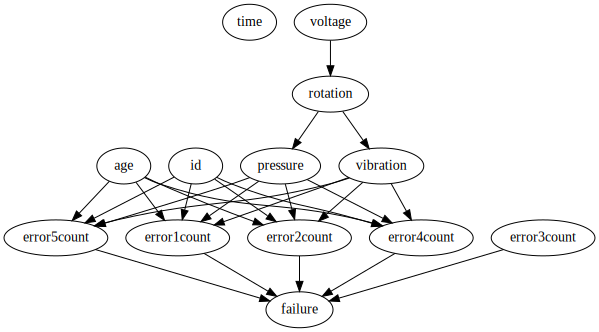

In [91]:
NewSCM().draw()
# newSCM.draw()

In [83]:
data_e0 = tstDataPd.copy()
data_e0['error3count'] = 0.0 #This procedure is equivalent to d-sperating error3count from its causes as shown in the graph above and intervening to set the value of error3count
fail_pred_0= model.predict_proba(data_e0[['voltmean', 'rotatemean', 'pressuremean', 'vibrationmean','model', 'age', 'error1count', 'error2count', 'error3count', 'error4count', 'error5count']])

data_e2 = tstDataPd.copy()
data_e2['error3count'] = 2.0 #This procedure is equivalent to d-sperating error3count from its causes as shown in the graph above and intervening to set the value of error3count
fail_pred_2= model.predict_proba(data_e2[['voltmean', 'rotatemean', 'pressuremean', 'vibrationmean','model', 'age', 'error1count', 'error2count', 'error3count', 'error4count', 'error5count']])

# now, let's check the difference in probabilities
fail_pred_2[:, 1].mean() - fail_pred_0[:,1].mean() #Calculating the average causal effect

0.5200707004590494

Regressions above give an estimate difference that is closer to the true effect of $error3count$. In fact, it gives us the Average Causal Effect (ACE) which is expressed as:
$$
\begin{equation}
ACE = P(F_{3}|do(Err_3=2)) - P(F_{0}|do(Err_3=0))
\end{equation}
$$

In [90]:
def NewSCM():
    machine_SCM = CausalGraphicalModel(
        nodes=['voltage', 'time', 'rotation', 'pressure', 'vibration', 'id', 'age', 'error1count', 'error2count', 'error3count', 'error4count', 'error5count', 'failure'],
        edges=[
            ('voltage', 'rotation'),
            ('rotation', 'pressure'),
            ('rotation', 'vibration'),

            ('pressure', 'error1count'),
            ('vibration', 'error1count'),
            ('id', 'error1count'),
            ('age', 'error1count'),
            ('error1count', 'failure'),

            ('pressure', 'error2count'),
            ('vibration', 'error2count'),
            ('id', 'error2count'),
            ('age', 'error2count'),
            ('error2count', 'failure'),

            ('error3count', 'failure'),

            ('pressure', 'error4count'),
            ('vibration', 'error4count'),
            ('id', 'error4count'),
            ('age', 'error4count'),
            ('error4count', 'failure'),

            ('pressure', 'error5count'),
            ('vibration', 'error5count'),
            ('id', 'error5count'),
            ('age', 'error5count'),
            ('error5count', 'failure')
        ]
    )
    return machine_SCM

In [20]:
def typeCastData(data) :
    data['voltmean'] = data['voltmean'].astype('float64')
    data['voltsd'] = data['voltsd'].astype('float64')
    data['rotatemean'] = data['rotatemean'].astype('float64')
    data['rotatesd'] = data['rotatesd'].astype('float64')
    data['pressuremean'] = data['pressuremean'].astype('float64')
    data['pressuresd'] = data['pressuresd'].astype('float64')
    data['vibrationmean'] = data['vibrationmean'].astype('float64')
    data['vibrationsd'] = data['vibrationsd'].astype('float64')
    data['error1count'] = data['error1count'].astype('float64')
    data['error2count'] = data['error2count'].astype('float64')
    data['error3count'] = data['error3count'].astype('float64')
    data['error4count'] = data['error4count'].astype('float64')
    data['error5count'] = data['error5count'].astype('float64')
    data['model'] = data['model'].astype('float64')
    data['age'] = data['age'].astype('float64')
    data['failure'] =  data['failure'].astype(bool)
    return data